# Phase 4: Rasterization Pipeline — Verification

Converts room polygons + door positions into 64×64 3-channel images for CNN input.
This notebook verifies the rasterization, runs dataset-wide sanity checks, and compares
UMAP embeddings of rasterized images vs tabular features from [Phase 3 EDA](./02_umap_exploration.ipynb).

**Module**: `src/furnisher_surrogate/rasterize.py` | **Plan**: [plans/04-rasterization.md](../plans/04-rasterization.md)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from pathlib import Path

from furnisher_surrogate.data import load_apartments, load_rooms, ROOM_TYPES
from furnisher_surrogate.features import (
    area as compute_area, aspect_ratio, n_vertices, door_rel_position,
)
from furnisher_surrogate.rasterize import rasterize_room, IMG_SIZE

plt.rcParams.update({"figure.dpi": 120, "figure.facecolor": "white"})

# Load data
apartments = load_apartments()
all_rooms = [r for a in apartments for r in a.rooms]
print(f"Loaded {len(apartments)} apartments, {len(all_rooms)} rooms")

Loaded 8322 apartments, 45880 rooms


## 1. Visual Verification — Side-by-Side Comparison

For each room type, pick one representative room and show:
- **Left**: original polygon outline + door dot (matplotlib)
- **Right**: rasterized 3-channel image as RGB composite
- **Below**: individual channels (mask, edges, door blob)

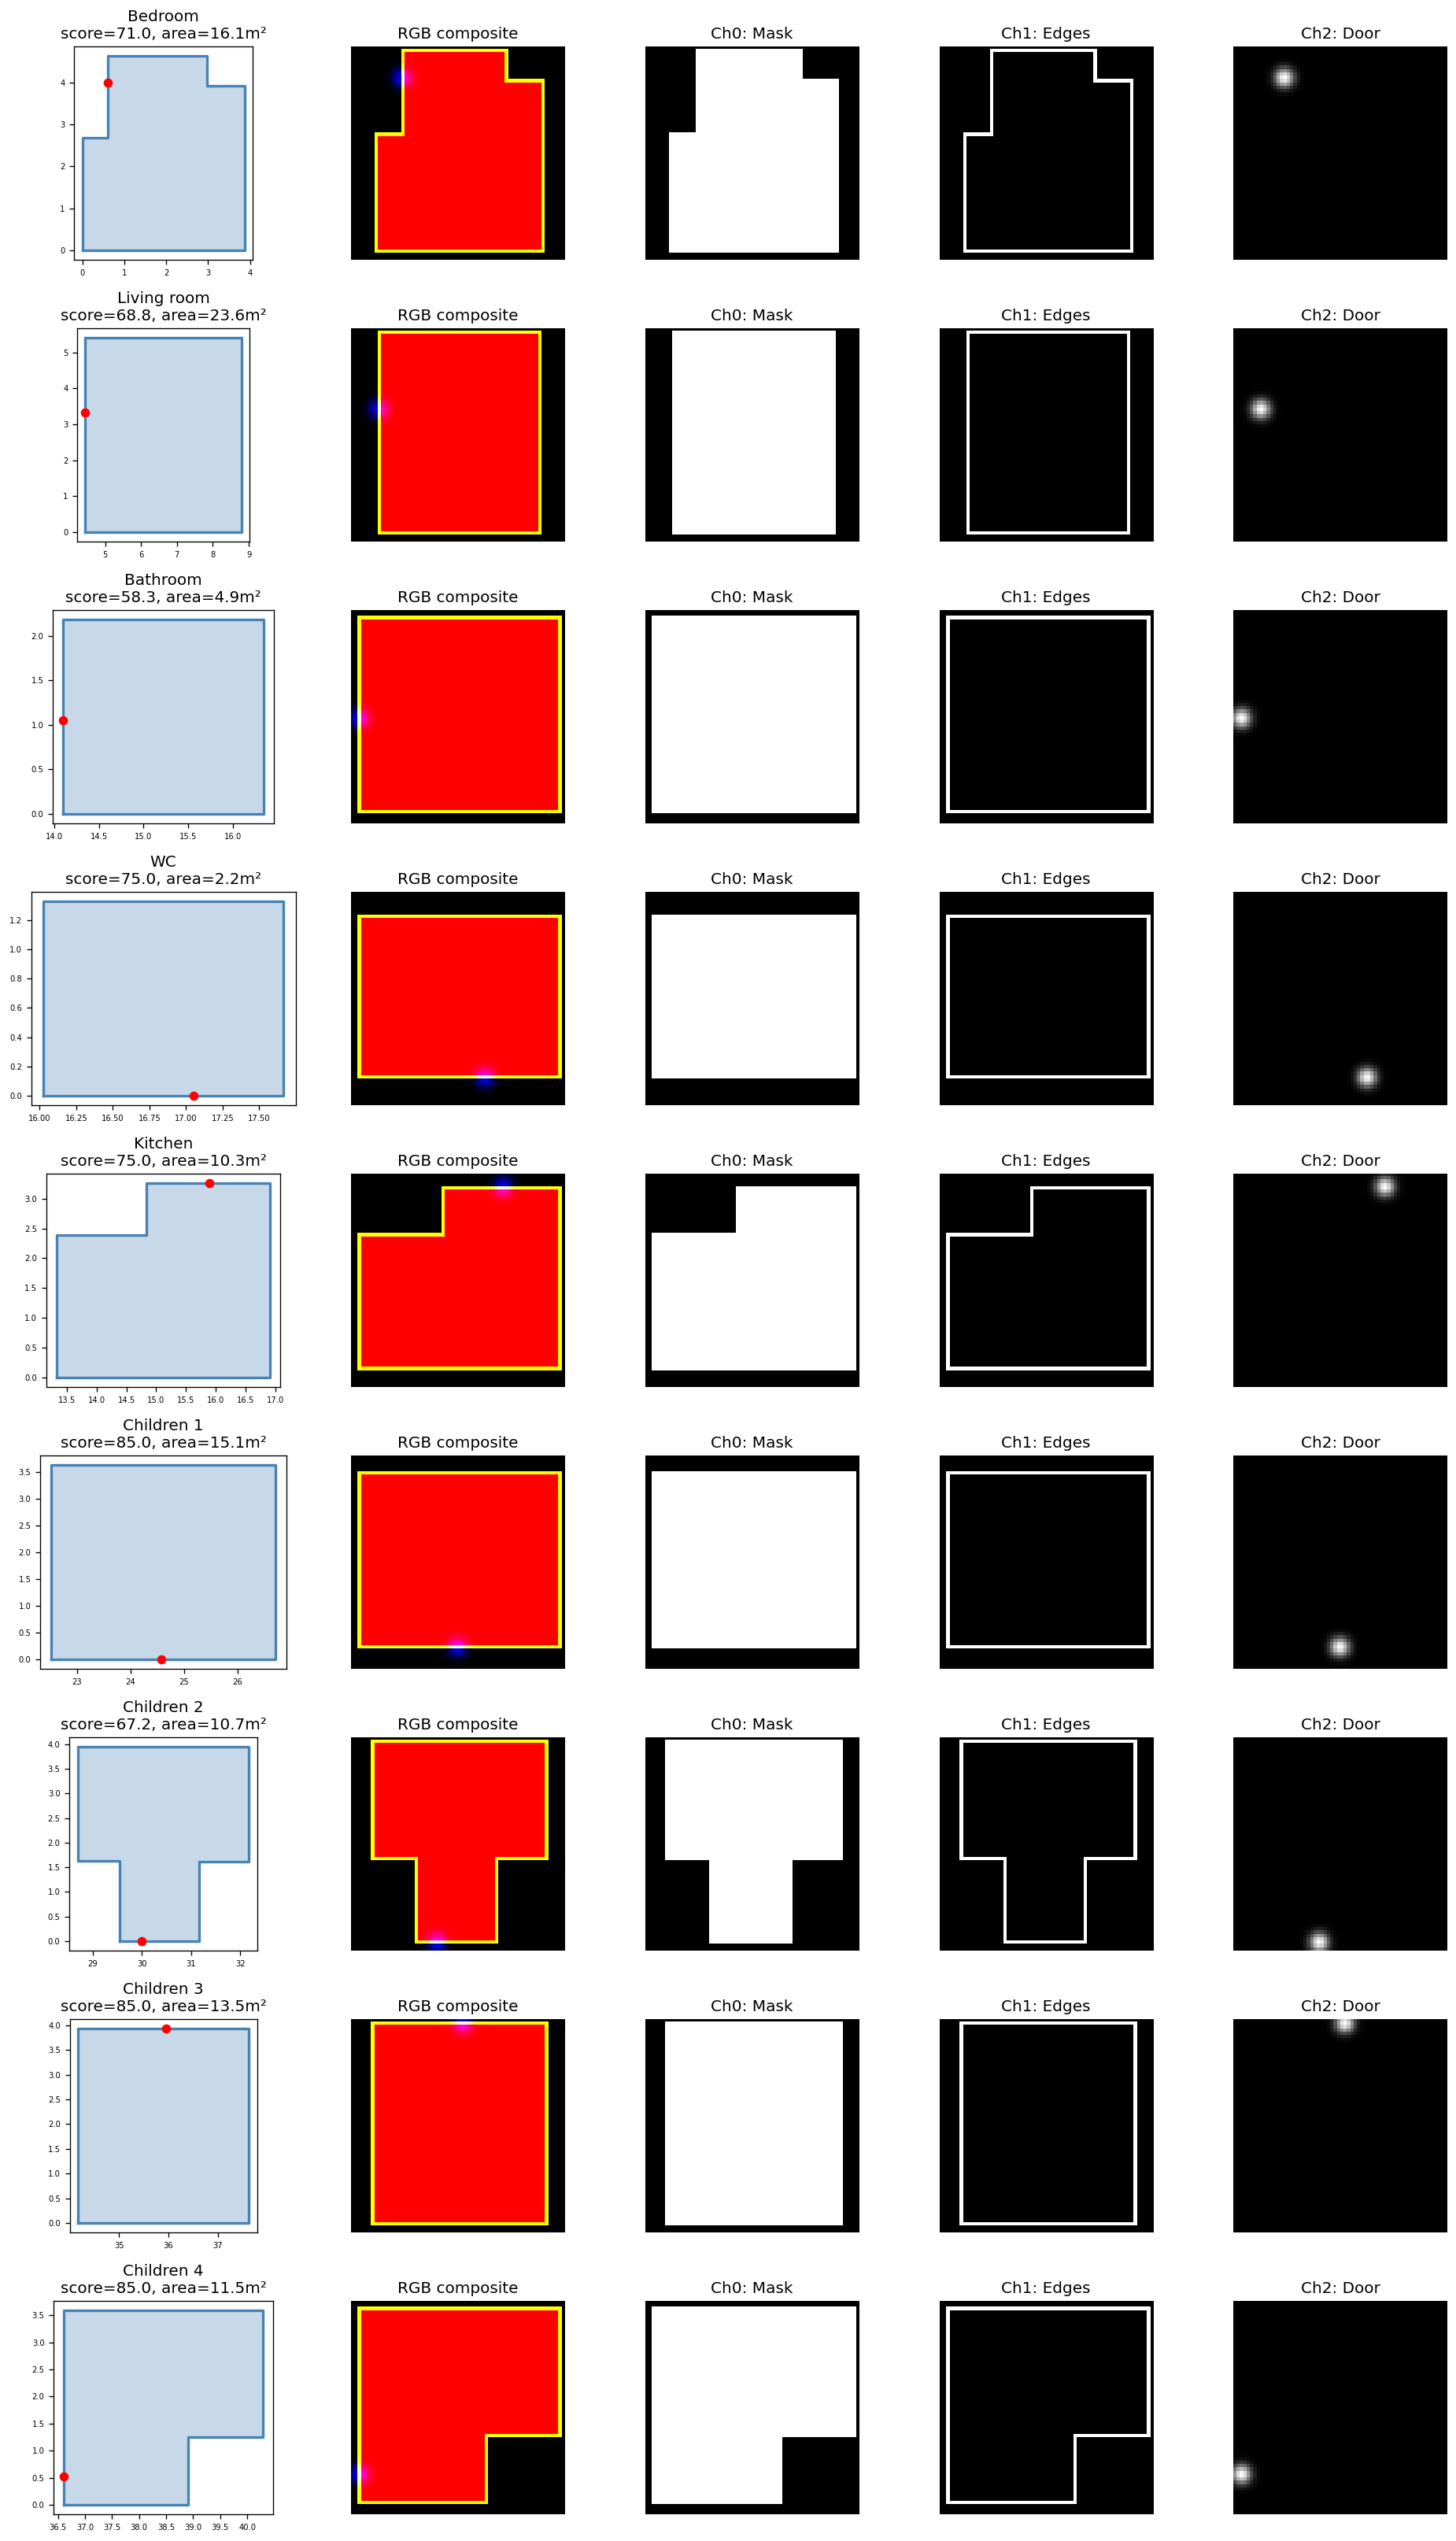

In [2]:
# Pick one representative room per room type (prefer mid-scoring rooms for visual interest)
representatives = {}
for room in all_rooms:
    rt = room.room_type
    if rt not in representatives:
        representatives[rt] = room
    elif room.score is not None and 40 < room.score < 90:
        # Prefer mid-scoring rooms (more interesting shapes)
        if representatives[rt].score is None or not (40 < representatives[rt].score < 90):
            representatives[rt] = room

fig, axes = plt.subplots(len(ROOM_TYPES), 5, figsize=(16, 3 * len(ROOM_TYPES)))

for row, rt in enumerate(ROOM_TYPES):
    room = representatives[rt]
    img = rasterize_room(room)
    poly = room.polygon

    # Col 0: Original polygon
    ax = axes[row, 0]
    ax.fill(poly[:, 0], poly[:, 1], alpha=0.3, color="steelblue")
    ax.plot(poly[:, 0], poly[:, 1], color="steelblue", linewidth=2)
    ax.plot(*room.door, "ro", markersize=6)
    ax.set_aspect("equal")
    ax.set_title(f"{rt}\nscore={room.score}, area={compute_area(room):.1f}m²")
    ax.tick_params(labelsize=6)

    # Col 1: RGB composite of rasterized image
    ax = axes[row, 1]
    rgb = np.stack([img[0], img[1], img[2]], axis=-1)  # mask=R, edges=G, door=B
    ax.imshow(rgb)
    ax.set_title("RGB composite")
    ax.axis("off")

    # Cols 2-4: Individual channels
    channel_names = ["Ch0: Mask", "Ch1: Edges", "Ch2: Door"]
    for c in range(3):
        ax = axes[row, 2 + c]
        ax.imshow(img[c], cmap="gray", vmin=0, vmax=255)
        ax.set_title(channel_names[c])
        ax.axis("off")

plt.tight_layout()
plt.show()

## 2. Edge Cases — Shape Variety

Test rooms with different vertex counts (4=rectangle, 6=L-shape, 8=notched),
extreme aspect ratios, and small areas.

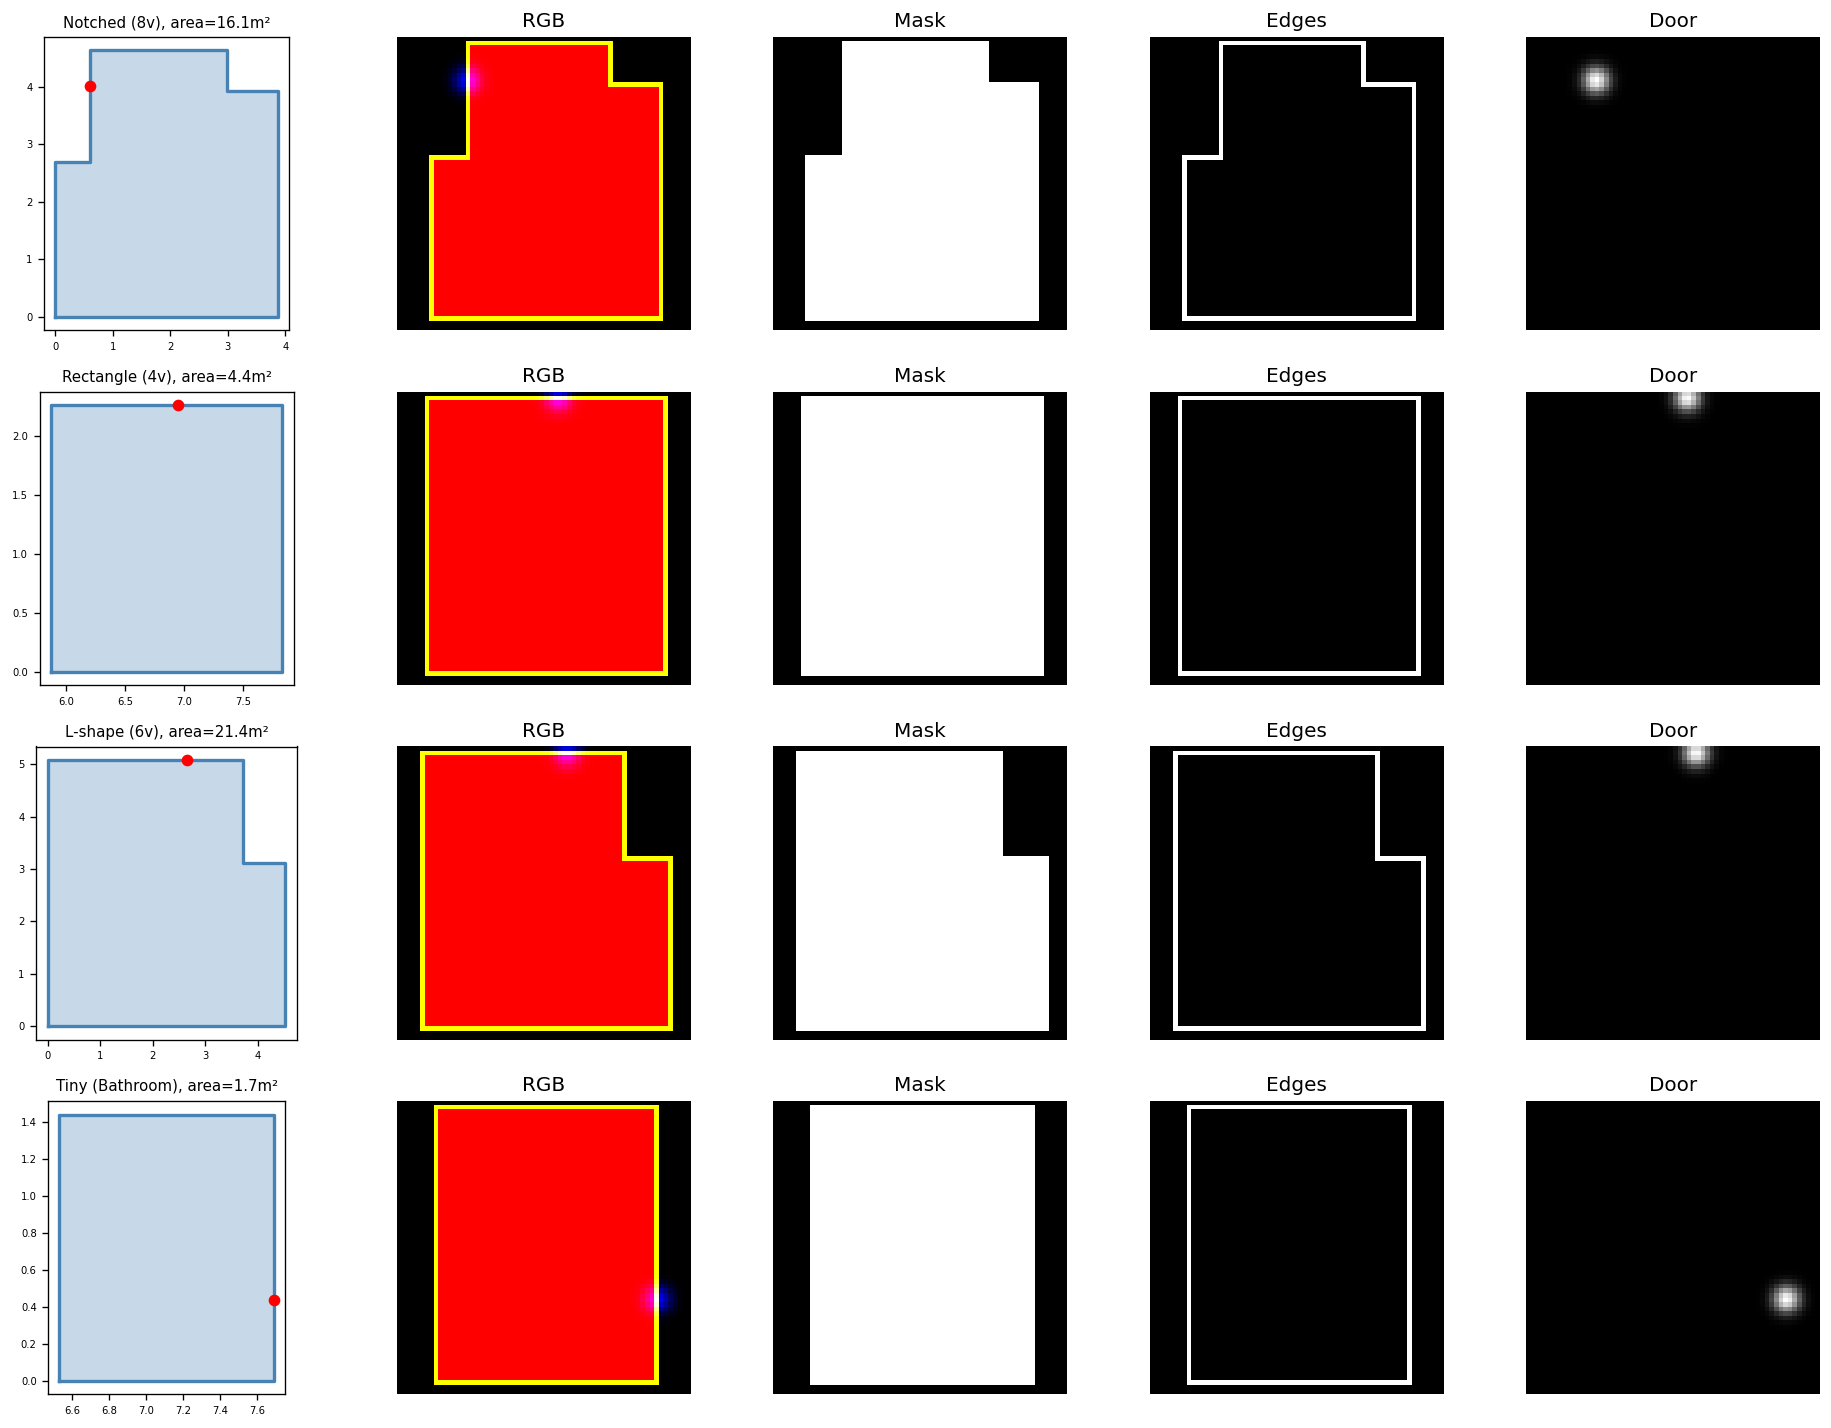

In [3]:
# Find edge cases
cases = {}
for room in all_rooms:
    nv = n_vertices(room)
    ar = aspect_ratio(room)
    a = compute_area(room)

    if nv == 4 and "rect" not in cases:
        cases["rect"] = (room, f"Rectangle (4v), area={a:.1f}m²")
    if nv == 6 and "lshape" not in cases:
        cases["lshape"] = (room, f"L-shape (6v), area={a:.1f}m²")
    if nv == 8 and "notched" not in cases:
        cases["notched"] = (room, f"Notched (8v), area={a:.1f}m²")
    if ar > 3.0 and "elongated" not in cases:
        cases["elongated"] = (room, f"Elongated (AR={ar:.1f}), area={a:.1f}m²")
    if a < 2.0 and "tiny" not in cases:
        cases["tiny"] = (room, f"Tiny ({room.room_type}), area={a:.1f}m²")

fig, axes = plt.subplots(len(cases), 5, figsize=(16, 3 * len(cases)))

for row, (key, (room, label)) in enumerate(cases.items()):
    img = rasterize_room(room)
    poly = room.polygon

    ax = axes[row, 0]
    ax.fill(poly[:, 0], poly[:, 1], alpha=0.3, color="steelblue")
    ax.plot(poly[:, 0], poly[:, 1], color="steelblue", linewidth=2)
    ax.plot(*room.door, "ro", markersize=6)
    ax.set_aspect("equal")
    ax.set_title(label, fontsize=9)
    ax.tick_params(labelsize=6)

    ax = axes[row, 1]
    rgb = np.stack([img[0], img[1], img[2]], axis=-1)
    ax.imshow(rgb)
    ax.set_title("RGB")
    ax.axis("off")

    for c in range(3):
        ax = axes[row, 2 + c]
        ax.imshow(img[c], cmap="gray", vmin=0, vmax=255)
        ax.set_title(["Mask", "Edges", "Door"][c])
        ax.axis("off")

plt.tight_layout()
plt.show()

## 3. Pixel-Level Sanity Checks

Since each room is normalized to fit 60px (per-room scaling), mask pixel count does **not**
correlate with real-world area — a 4m² and 40m² rectangle with the same aspect ratio produce
identical images. Instead, we validate:

1. **Fill ratio vs vertex count** — rectangles (4v) should fill ~100% of their bounding box in the image, L-shapes (6v) ~75%, notched rooms (8v) less. This confirms concave polygon rendering works.
2. **Door blob on wall** — the gaussian peak should always land on or near an edge pixel.

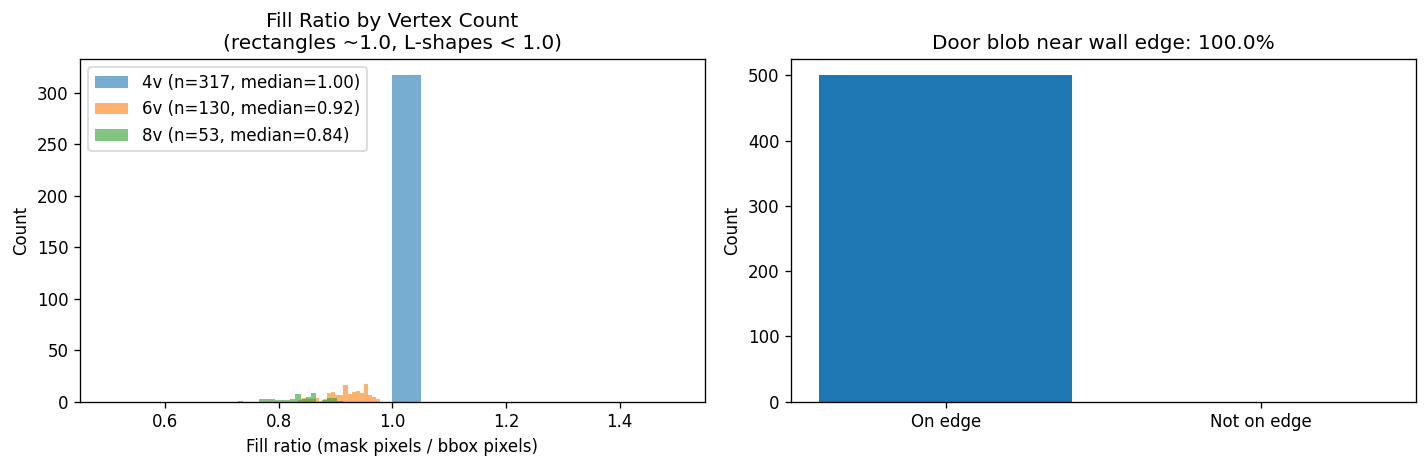

Fill ratio by vertex count:
  4 vertices: median=1.000, mean=1.000 (n=317)
  6 vertices: median=0.922, mean=0.919 (n=130)
  8 vertices: median=0.840, mean=0.838 (n=53)

Door on edge: 500/500 (100.0%)


In [4]:
# Sanity checks on a sample of rooms
np.random.seed(42)
sample_idx = np.random.choice(len(all_rooms), size=500, replace=False)
sample_rooms = [all_rooms[i] for i in sample_idx]

vertex_counts = []
fill_ratios = []
door_on_mask_edge = []

for room in sample_rooms:
    img = rasterize_room(room)
    nv = n_vertices(room)
    vertex_counts.append(nv)

    # Fill ratio: mask pixels / bounding box pixels in image
    mask = img[0] > 0
    rows_any = mask.any(axis=1)
    cols_any = mask.any(axis=0)
    if rows_any.any() and cols_any.any():
        bbox_h = rows_any.sum()
        bbox_w = cols_any.sum()
        fill_ratios.append(mask.sum() / (bbox_h * bbox_w))
    else:
        fill_ratios.append(0.0)

    # Check door blob peak falls on or adjacent to wall edge
    door_ch = img[2]
    peak_yx = np.unravel_index(door_ch.argmax(), door_ch.shape)
    y, x = peak_yx
    neighborhood = img[1][max(0, y-2):y+3, max(0, x-2):x+3]
    door_on_mask_edge.append(neighborhood.max() > 0)

vertex_counts = np.array(vertex_counts)
fill_ratios = np.array(fill_ratios)

# Plot 1: Fill ratio by vertex count
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

for nv in [4, 6, 8]:
    mask_nv = vertex_counts == nv
    if mask_nv.any():
        vals = fill_ratios[mask_nv]
        ax1.hist(vals, bins=20, alpha=0.6, label=f"{nv}v (n={mask_nv.sum()}, median={np.median(vals):.2f})")

ax1.set_xlabel("Fill ratio (mask pixels / bbox pixels)")
ax1.set_ylabel("Count")
ax1.set_title("Fill Ratio by Vertex Count\n(rectangles ~1.0, L-shapes < 1.0)")
ax1.legend()

# Plot 2: Door on edge check
pct_on_edge = 100 * sum(door_on_mask_edge) / len(door_on_mask_edge)
ax2.bar(["On edge", "Not on edge"],
        [sum(door_on_mask_edge), len(door_on_mask_edge) - sum(door_on_mask_edge)])
ax2.set_title(f"Door blob near wall edge: {pct_on_edge:.1f}%")
ax2.set_ylabel("Count")

plt.tight_layout()
plt.show()

print(f"Fill ratio by vertex count:")
for nv in [4, 6, 8]:
    mask_nv = vertex_counts == nv
    if mask_nv.any():
        print(f"  {nv} vertices: median={np.median(fill_ratios[mask_nv]):.3f}, "
              f"mean={fill_ratios[mask_nv].mean():.3f} (n={mask_nv.sum()})")
print(f"\nDoor on edge: {sum(door_on_mask_edge)}/{len(door_on_mask_edge)} ({pct_on_edge:.1f}%)")

## 4. Pre-Rasterized Dataset — Load and Inspect

Load `data/rooms_rasterized.npz` and verify contents.

In [5]:
npz_path = Path("../data/rooms_rasterized.npz")
data = np.load(npz_path)

print(f"File: {npz_path} ({npz_path.stat().st_size / 1e6:.1f} MB)")
print(f"\nArrays:")
for key in data.files:
    arr = data[key]
    print(f"  {key:20s} shape={str(arr.shape):20s} dtype={arr.dtype}")

images = data["images"]
scores = data["scores"]
room_type_idx = data["room_type_idx"]

# Per-channel statistics
print(f"\nPer-channel statistics (over all {len(images)} images):")
for c, name in enumerate(["Mask", "Edges", "Door"]):
    ch = images[:, c]
    nonzero_pct = 100 * (ch > 0).mean()
    print(f"  Ch{c} ({name:5s}): mean={ch.mean():.2f}, std={ch.std():.2f}, nonzero={nonzero_pct:.1f}%")

# Any all-zero images?
all_zero = (images.sum(axis=(1, 2, 3)) == 0).sum()
print(f"\nAll-zero images: {all_zero}")

File: ..\data\rooms_rasterized.npz (8.7 MB)

Arrays:


  images               shape=(45880, 3, 64, 64)   dtype=uint8
  scores               shape=(45880,)             dtype=float32
  room_type_idx        shape=(45880,)             dtype=int8
  area                 shape=(45880,)             dtype=float32
  door_rel_x           shape=(45880,)             dtype=float32
  door_rel_y           shape=(45880,)             dtype=float32
  apartment_seeds      shape=(45880,)             dtype=int64



Per-channel statistics (over all 45880 images):


  Ch0 (Mask ): mean=186.32, std=113.12, nonzero=73.1%


  Ch1 (Edges): mean=13.72, std=57.54, nonzero=5.4%


  Ch2 (Door ): mean=1.42, std=13.70, nonzero=2.8%



All-zero images: 0


## 5. Random Sample Grid

5×5 grid of random rooms displayed as RGB composites with score in title.

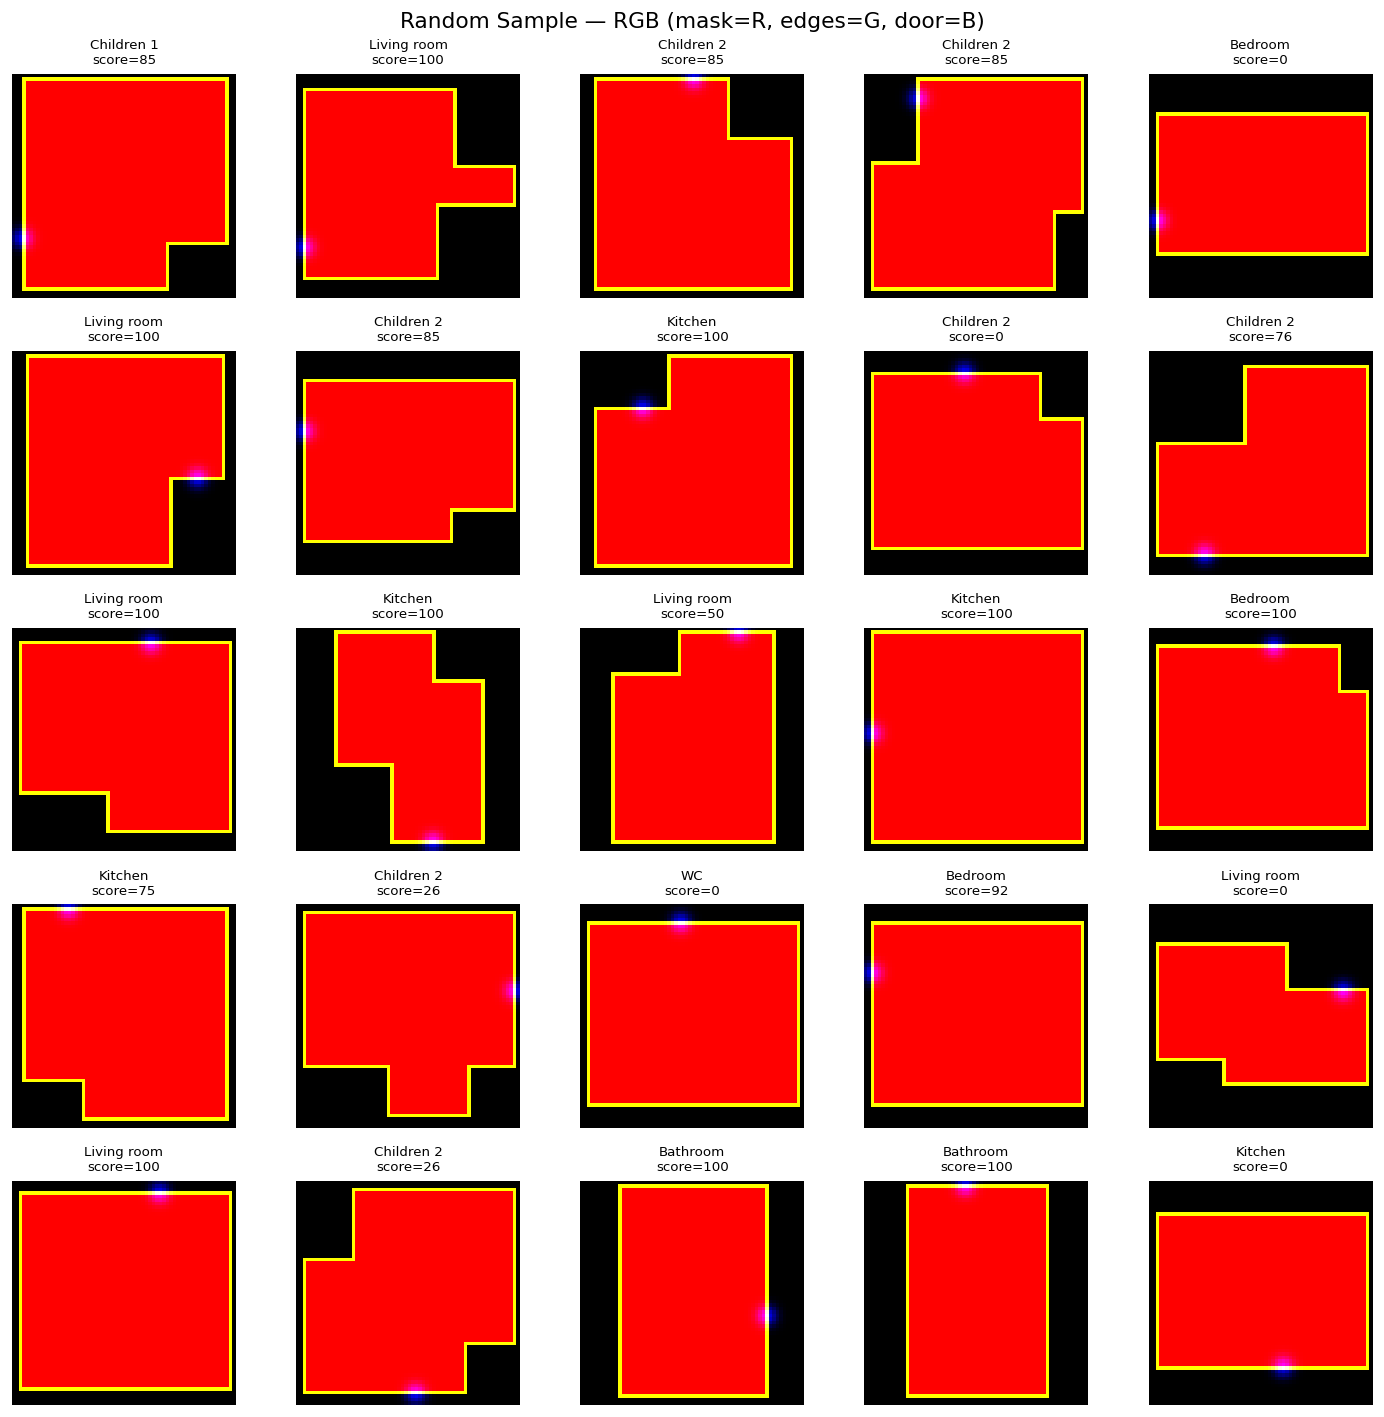

In [6]:
np.random.seed(123)
sample = np.random.choice(len(images), size=25, replace=False)

fig, axes = plt.subplots(5, 5, figsize=(12, 12))
for i, idx in enumerate(sample):
    ax = axes[i // 5, i % 5]
    img = images[idx]
    rgb = np.stack([img[0], img[1], img[2]], axis=-1)
    ax.imshow(rgb)
    rt = ROOM_TYPES[room_type_idx[idx]]
    ax.set_title(f"{rt}\nscore={scores[idx]:.0f}", fontsize=8)
    ax.axis("off")

plt.suptitle("Random Sample — RGB (mask=R, edges=G, door=B)", fontsize=13)
plt.tight_layout()
plt.show()

## 6. UMAP on Rasterized Images

Flatten 3×64×64 images to 12,288-dim vectors, subsample 10k rooms (stratified),
fit UMAP, and compare to Phase 3 tabular UMAP.

**Key question**: Does spatial structure (captured by images) add information
beyond the 5 numeric features?

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit
import umap
import plotly.express as px
import pandas as pd

# Stratified subsample of 10,000 rooms
n_subsample = 10_000
sss = StratifiedShuffleSplit(n_splits=1, train_size=n_subsample, random_state=42)
sub_idx, _ = next(sss.split(np.arange(len(images)), room_type_idx))

sub_images = images[sub_idx]
sub_scores = scores[sub_idx]
sub_types = room_type_idx[sub_idx]
sub_areas = data["area"][sub_idx]

# Flatten to (N, 12288) and normalize to [0, 1]
X_flat = sub_images.reshape(len(sub_images), -1).astype(np.float32) / 255.0
print(f"UMAP input: {X_flat.shape}")

# Fit UMAP (same params as Phase 3 for fair comparison)
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(X_flat)
print(f"UMAP done: {embedding.shape}")

# Build DataFrame for plotly
df = pd.DataFrame({
    "UMAP1": embedding[:, 0],
    "UMAP2": embedding[:, 1],
    "score": sub_scores,
    "room_type": [ROOM_TYPES[i] for i in sub_types],
    "area": sub_areas,
})

fig = px.scatter(
    df, x="UMAP1", y="UMAP2", color="score",
    hover_data=["room_type", "area", "score"],
    color_continuous_scale="RdYlGn",
    title="UMAP on Rasterized Images (10k subsample) — Color by Score",
    width=800, height=600,
)
fig.update_traces(marker=dict(size=3, opacity=0.6))
fig.show()

# Also color by room type
fig2 = px.scatter(
    df, x="UMAP1", y="UMAP2", color="room_type",
    hover_data=["score", "area"],
    title="UMAP on Rasterized Images (10k subsample) — Color by Room Type",
    width=800, height=600,
)
fig2.update_traces(marker=dict(size=3, opacity=0.6))
fig2.show()

UMAP input: (10000, 12288)


C:\Users\MartinBielik\Dev\SpatialTimber\SpatialTimber_FurnisherSurrogate\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP done: (10000, 2)


## Checkpoint Summary

**Rasterization pipeline verified:**
- `rasterize_room()` produces (3, 64, 64) uint8 images with correct mask, edge, and door channels
- Visual comparison confirms polygon shapes match rasterized images
- Edge cases (L-shapes, notched rooms, tiny rooms, elongated rooms) handled correctly
- Pre-rasterized dataset: 45,880 images in `data/rooms_rasterized.npz`
- UMAP on rasterized images compared to Phase 3 tabular UMAP

**Ready for**: Phase 5 (Baseline Model) and Phase 6 (CNN Model)